<a href="https://www.kaggle.com/code/aisuko/text-to-image-with-denoising?scriptVersionId=164179636" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

## Overview

In this notebook, we are going to use `google/ddpm-cat-256` with the scheduler `google/ddpm-cat-256` to generate a image from a random input.

In [1]:
%%capture
!pip install diffusers==0.26.3
!pip install accelerate==0.27.2
# ImportError: cannot import name 'CpuOffload' from 'accelerate.hooks'
!pip install transformers==4.38.1

# Loading the Model and Scheduler

In [2]:
import torch
from diffusers import DDPMScheduler, UNet2DModel

if torch.cuda.is_available():
    torch.backends.cudnn.deterministic=True
    torch_device='cuda'
else:
    torch_device='cpu'

model = UNet2DModel.from_pretrained('google/ddpm-cat-256').to(torch_device)

# Print model's state_dict
print("Model's state_dict:")
for param_tensor in model.state_dict():
    print(param_tensor, "\t", model.state_dict()[param_tensor].size())

The cache for model files in Transformers v4.22.0 has been updated. Migrating your old cache. This is a one-time only operation. You can interrupt this and resume the migration later on by calling `transformers.utils.move_cache()`.


0it [00:00, ?it/s]

config.json:   0%|          | 0.00/790 [00:00<?, ?B/s]

diffusion_pytorch_model.safetensors:   0%|          | 0.00/455M [00:00<?, ?B/s]

Model's state_dict:
conv_in.weight 	 torch.Size([128, 3, 3, 3])
conv_in.bias 	 torch.Size([128])
time_embedding.linear_1.weight 	 torch.Size([512, 128])
time_embedding.linear_1.bias 	 torch.Size([512])
time_embedding.linear_2.weight 	 torch.Size([512, 512])
time_embedding.linear_2.bias 	 torch.Size([512])
down_blocks.0.resnets.0.norm1.weight 	 torch.Size([128])
down_blocks.0.resnets.0.norm1.bias 	 torch.Size([128])
down_blocks.0.resnets.0.conv1.weight 	 torch.Size([128, 128, 3, 3])
down_blocks.0.resnets.0.conv1.bias 	 torch.Size([128])
down_blocks.0.resnets.0.time_emb_proj.weight 	 torch.Size([128, 512])
down_blocks.0.resnets.0.time_emb_proj.bias 	 torch.Size([128])
down_blocks.0.resnets.0.norm2.weight 	 torch.Size([128])
down_blocks.0.resnets.0.norm2.bias 	 torch.Size([128])
down_blocks.0.resnets.0.conv2.weight 	 torch.Size([128, 128, 3, 3])
down_blocks.0.resnets.0.conv2.bias 	 torch.Size([128])
down_blocks.0.resnets.1.norm1.weight 	 torch.Size([128])
down_blocks.0.resnets.1.norm1.bia

In [3]:
# load the model and scheduler
scheduler = DDPMScheduler.from_pretrained('google/ddpm-cat-256')
print(scheduler)

scheduler_config.json:   0%|          | 0.00/256 [00:00<?, ?B/s]

DDPMScheduler {
  "_class_name": "DDPMScheduler",
  "_diffusers_version": "0.26.3",
  "beta_end": 0.02,
  "beta_schedule": "linear",
  "beta_start": 0.0001,
  "clip_sample": true,
  "clip_sample_range": 1.0,
  "dynamic_thresholding_ratio": 0.995,
  "num_train_timesteps": 1000,
  "prediction_type": "epsilon",
  "rescale_betas_zero_snr": false,
  "sample_max_value": 1.0,
  "steps_offset": 0,
  "thresholding": false,
  "timestep_spacing": "leading",
  "trained_betas": null,
  "variance_type": "fixed_small"
}



# Setting the Scheduler Timtsteps

We are creating a tensor with evenly spaced elements in it. $25$ in this case. Each element corresponds to a timestep in at which the model denoises an image. When you create the denoising loop later, you will iterate over this tensor to denoise an image:

In [4]:
# Set the number of timesteps to run the denoising process
scheduler.set_timesteps(25)
scheduler.timesteps

tensor([960, 920, 880, 840, 800, 760, 720, 680, 640, 600, 560, 520, 480, 440,
        400, 360, 320, 280, 240, 200, 160, 120,  80,  40,   0])

# Creating Noise

Create some random noise with the same shape as the desited output.

In [5]:
sample_size =model.config.sample_size

# we create a random tensor as the text input
noise = torch.randn((1, 3, sample_size, sample_size)).to(torch_device)
noise.shape

torch.Size([1, 3, 256, 256])

# A Loop to Iterate Over the Timesteps

At each timestep, the model does a `UNet2DModel.forward()` pass and returns the noisy residual. The scheduler's `step()` method takes the noisy residual, timestep, and input and it predicts the image at the previous timestep. This output becomes the next input to the model in the denoising loop, and it'll repeat until it reaches the end of the timesteps array.

In [6]:
from tqdm import tqdm

input = noise

for t in tqdm(scheduler.timesteps):
    with torch.no_grad():
        noisy_residual=model(input, t).sample
    previous_noisy_sample = scheduler.step(noisy_residual, t, input).prev_sample
    input = previous_noisy_sample

100%|██████████| 25/25 [00:02<00:00,  9.81it/s]


# Convert the Denoised Output Into an Image

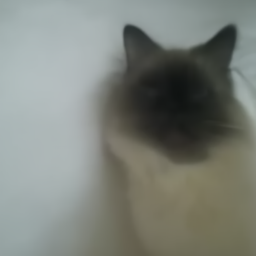

In [7]:
from PIL import Image
import numpy as np

image = (input /2 + 0.5).clamp(0, 1)
image=image.cpu().permute(0, 2, 3, 1).numpy()[0]
image = Image.fromarray((image * 255).round().astype(np.uint8))
image

# Conclusion

In summary, we initialize the necessary components, and set the number of timesteps to create a timestep array. The timestep array is used in the `denoising loop`, and for each element in this array, the model predicts a less noisy image. The `denoising loop` iterates over the timestep's, and at each timestep, it outputs a noisy residual and the scheduler uses it to predict a less noisy image at the previous timestep. The process is repated until you reach the end of the timestep array.